# Data Overview and Goals
The dataset is given by Kaggle, and it uncovers the factors that lead to employee attrition: [IBM HR Analytics Employee Attrition & Performance](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset)

It examines factors as:
- Education of employees
- Environment Satisfaction
- Job Involvement
- Job Satisfaction
- Performance Rating
- Relationship Satisfaction
- Work-Life Balance

The target, in this case is wether these factors contribute, and how do they contribute to employee attrition.
Let's have a look.

For this data project, we are going to use a Boosted Decision Tree with XGBoost algorithm, that is useful for binary classification.
The architecture behind the algorithm is:
- Given a training set of m examples:
    - For b = 1 ... B use sampling with replacement to create a new training set of m examples
    - Focus the attention on where the algorithm misclassified examples, making it more likely to pick from them to create another set, by assigning weights to the examples

# Dependencies

In [616]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
pd.set_option('display.max_columns', None)
RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility

# Data Analysis

Loading the Data

In [617]:
path = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = pd.read_csv(path)
df_EDA = df

In [618]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


General information:

In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Looping up into object columns to search for categorical data that needs to be one-hot encoded

In [620]:
#lets check which values can we have in all the columns that are not numerical, in order to analyze categorical data
for column in df.select_dtypes(include='object').columns:
    print(df[column].value_counts())
    print()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

EducationField
Life Sciences       606
Medical             464
Marketing           159
Technical Degree    132
Other                82
Human Resources      27
Name: count, dtype: int64

Gender
Male      882
Female    588
Name: count, dtype: int64

JobRole
Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: count, dtype: int64

MaritalStatus
Married     673
Single      470
Divorced    327
Name: count, dtype: int64

Over18
Y    1470
Name:

As we can see, there are categorical data, such as:
- BusinessTravel
- Department
- EducationField
- JobRole
- MaritalStatus
So we need to perform One-Hot Encoding to make it easier for our computer to handle it

There are also columns that contain (or might contain) binary values such as:
- Gender
- Over18
- OverTime
- Attrition (target value)


One-hot encoding for categorical data:
- As a reminder, one-hot encoding aims to transform a categorical variable with n outputs into n binary variables.

In [621]:
cat_variables = ['BusinessTravel',
                 'Department',
                 'EducationField',
                 'JobRole',
                 'MaritalStatus']

In [622]:
df = pd.get_dummies(data = df,
                    prefix=cat_variables,
                    columns=cat_variables)

In [623]:
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,Yes,1102,1,2,1,1,2,Female,94,3,2,4,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
1,49,No,279,8,1,1,2,3,Male,61,2,2,2,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,37,Yes,1373,2,2,1,4,4,Male,92,2,1,3,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True
3,33,No,1392,3,4,1,5,4,Female,56,3,1,3,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
4,27,No,591,2,1,1,7,1,Male,40,3,1,2,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False


In [624]:
#Let's transform all binary columns in numerical values
df.loc[df['Gender']=='Female','Gender']=0
df.loc[df['Gender']=='Male','Gender']=1
df.loc[df['Over18']!='Y','Over18']=0
df.loc[df['Over18']=='Y','Over18']=1
df.loc[df['OverTime']=='No','OverTime']=0
df.loc[df['OverTime']=='Yes','OverTime']=1
df.loc[df['Attrition']=='No','Attrition']=0
df.loc[df['Attrition']=='Yes','Attrition']=1
df = df.astype(int)


In [625]:
#Let's transform all the true and false data generated by the one-hot encoding in 1 and 0
df = df.astype(int)

In [626]:
df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,3,2,4,5993,19479,8,1,1,11,3,1,80,0,8,0,1,6,4,0,5,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,49,0,279,8,1,1,2,3,1,61,2,2,2,5130,24907,1,1,0,23,4,4,80,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,2,1,3,2090,2396,6,1,1,15,3,2,80,0,7,3,3,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,3,1,3,2909,23159,1,1,1,11,3,3,80,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,3,1,2,3468,16632,9,1,0,12,3,4,80,1,6,3,3,2,2,2,2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


General statistical information:

In [627]:
df.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,0.600000,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,1.0,0.282993,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,0.102041,0.188435,0.709524,0.042857,0.653741,0.303401,0.018367,0.412245,0.108163,0.315646,0.055782,0.089796,0.089116,0.035374,0.176190,0.069388,0.098639,0.054422,0.198639,0.221769,0.056463,0.222449,0.457823,0.319728
std,9.135373,0.367863,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,0.490065,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,0.0,0.450606,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.302805,0.391193,0.454137,0.202604,0.475939,0.459884,0.134321,0.492406,0.310692,0.464931,0.229579,0.285986,0.285008,0.184786,0.381112,0.254199,0.298279,0.226925,0.399112,0.415578,0.230891,0.416033,0.498387,0.466530
min,18.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,1.0,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,0.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,1.0,0.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.000000,0.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,1.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,1.0,0.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,

# Exploratory Data Analysis

Age distribution

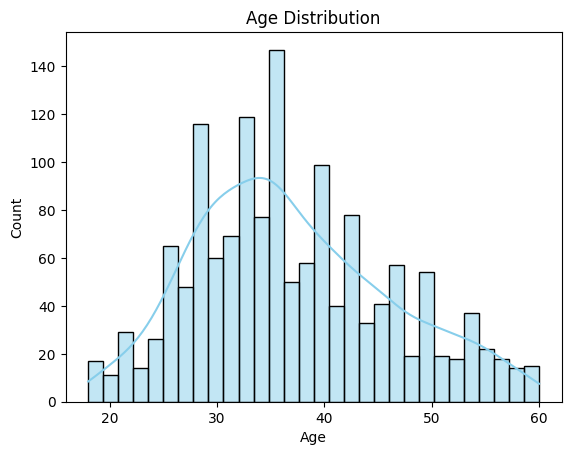

In [628]:
sns.histplot(data=df_EDA, x='Age', bins=30, kde=True, color='skyblue')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()


Gender Distribution

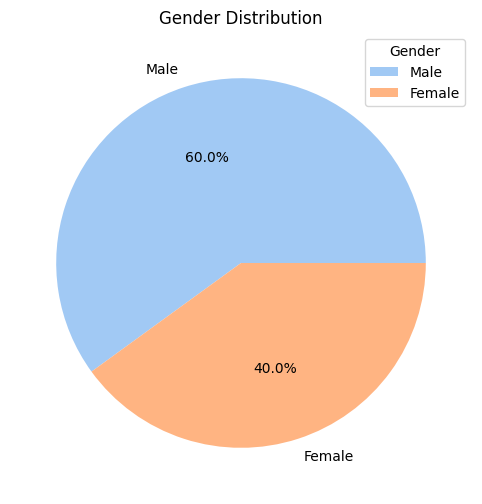

In [629]:
gender_counts = df_EDA['Gender'].value_counts()

# Calculate the percentage of each category
gender_percentages = (gender_counts / gender_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(gender_counts)]
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Gender', loc='upper right')
plt.title('Gender Distribution')
plt.show()

Marital Status Distribution

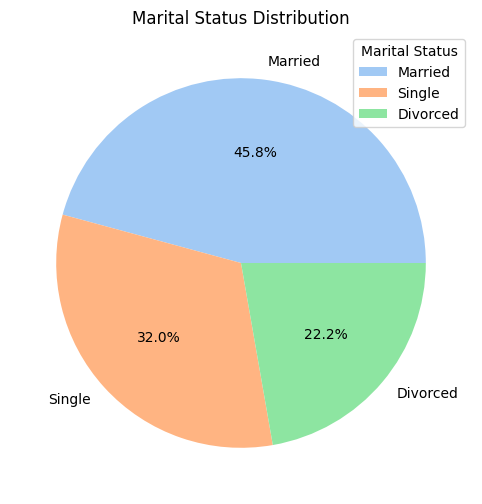

In [630]:
mstatus_counts = df_EDA['MaritalStatus'].value_counts()

# Calculate the percentage of each category
mstatus_percentages = (mstatus_counts / mstatus_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(mstatus_counts)]
plt.pie(mstatus_counts, labels=mstatus_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Marital Status', loc='upper right')
plt.title('Marital Status Distribution')
plt.show()

Education Distribution

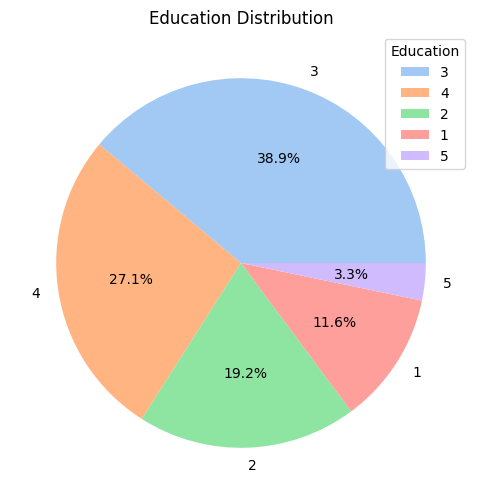

In [631]:
education_counts = df_EDA['Education'].value_counts()

# Calculate the percentage of each category
education_percentages = (education_counts / education_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(education_counts)]
plt.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Education', loc='upper right')
plt.title('Education Distribution')
plt.show()

To give a quick overview:
- 1 'Below College'
- 2 'College'
- 3 'Bachelor'
- 4 'Master'
- 5 'Doctor'

Education Field Distribution

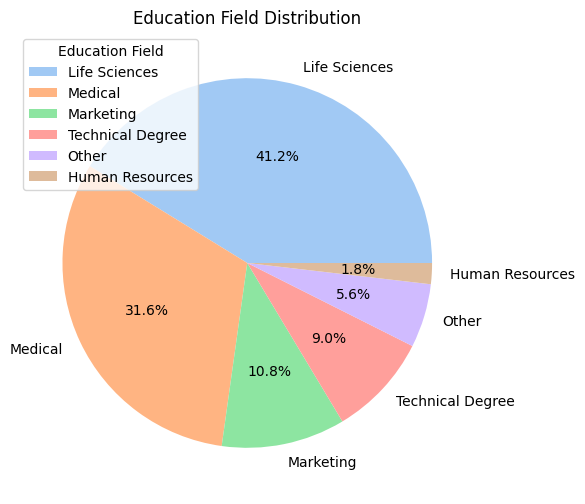

In [632]:
efield_counts = df_EDA['EducationField'].value_counts()

# Calculate the percentage of each category
efield_percentages = (efield_counts / efield_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(efield_counts)]
plt.pie(efield_counts, labels=efield_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Education Field', loc='upper left')
plt.title('Education Field Distribution')
plt.show()

Business-Travel Distribution

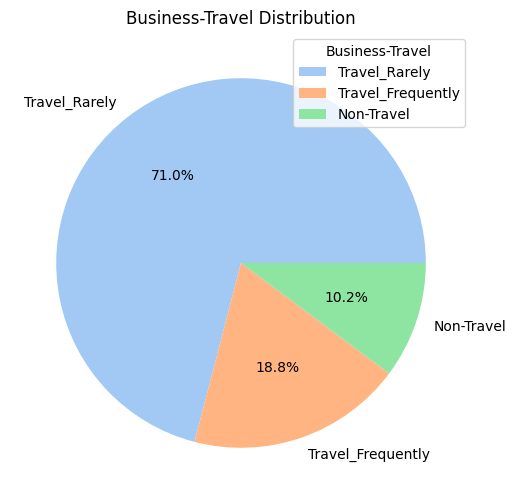

In [633]:
travel_counts = df_EDA['BusinessTravel'].value_counts()

# Calculate the percentage of each category
travel_percentages = (travel_counts / travel_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(travel_counts)]
plt.pie(travel_counts, labels=travel_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Business-Travel', loc='upper right')
plt.title('Business-Travel Distribution')
plt.show()

Department Distribution

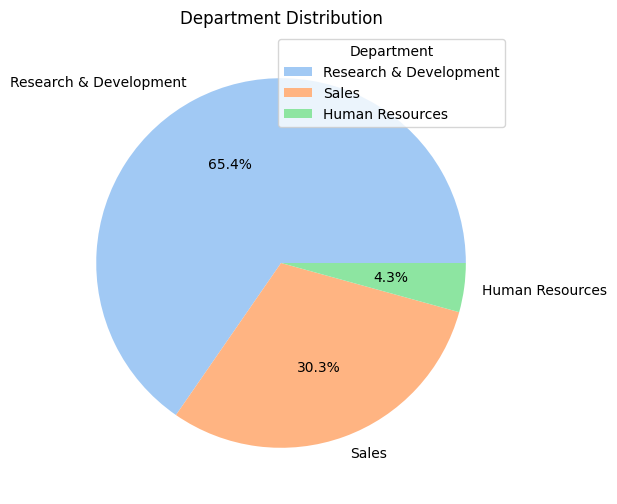

In [634]:
department_counts = df_EDA['Department'].value_counts()

# Calculate the percentage of each category
department_percentages = (department_counts / department_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(department_counts)]
plt.pie(department_counts, labels=department_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Department', loc='upper right')
plt.title('Department Distribution')
plt.show()

Job Role Distribution

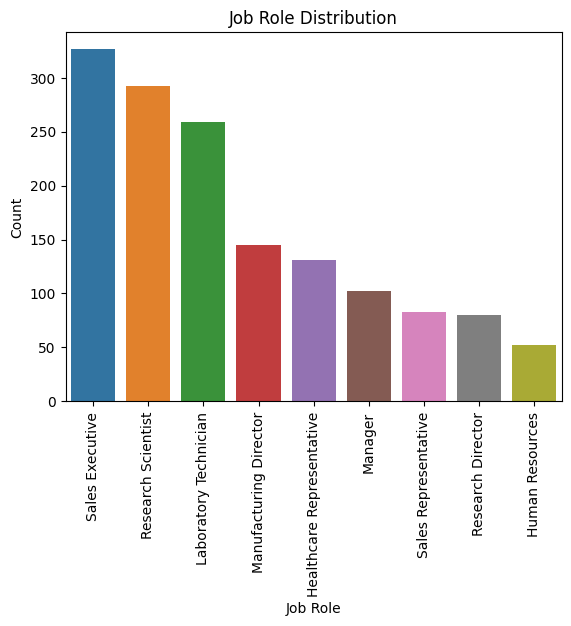

In [635]:
sns.countplot(data=df_EDA, x='JobRole')
plt.xlabel('Job Role')
plt.ylabel('Count')
plt.title('Job Role Distribution')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

Over Time Distribution

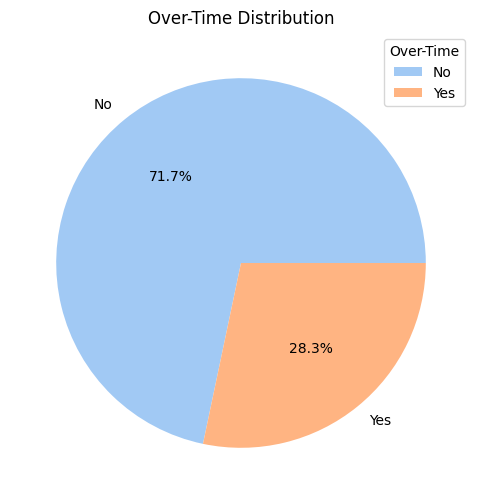

In [636]:
ot_counts = df_EDA['OverTime'].value_counts()

# Calculate the percentage of each category
ot_percentages = (ot_counts / ot_counts.sum()) * 100

# Create a pie plot using seaborn
plt.figure(figsize=(8, 6))
colors = sns.color_palette('pastel')[0:len(ot_counts)]
plt.pie(ot_counts, labels=ot_counts.index, autopct='%1.1f%%', colors=colors)

# Add count and percentage labels
plt.gca().set_aspect("equal")  # Ensure pie is drawn as a circle
plt.legend(title='Over-Time', loc='upper right')
plt.title('Over-Time Distribution')
plt.show()

# Bivariate Analysis

Age vs Distance From Home

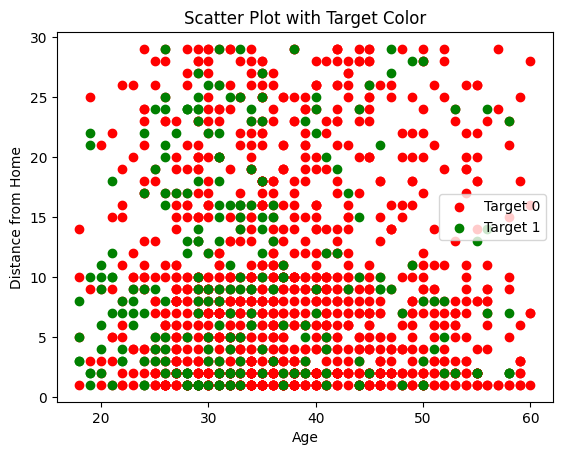

In [637]:
# Extract the 'Age', 'DistancefromHome', and 'y_train' columns from the DataFrame
x1 = df['Age']
x2 = df['DistanceFromHome']
y_train = df['Attrition']

# Create a scatter plot with red color for y_train == 0 and green color for y_train == 1
plt.scatter(x1[y_train == 0], x2[y_train == 0], color='red', label='Target 0')
plt.scatter(x1[y_train == 1], x2[y_train == 1], color='green', label='Target 1')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Distance from Home')
plt.title('Scatter Plot with Target Color')

# Add legend
plt.legend()

# Show the plot
plt.show()

Age vs Hourly Rate   

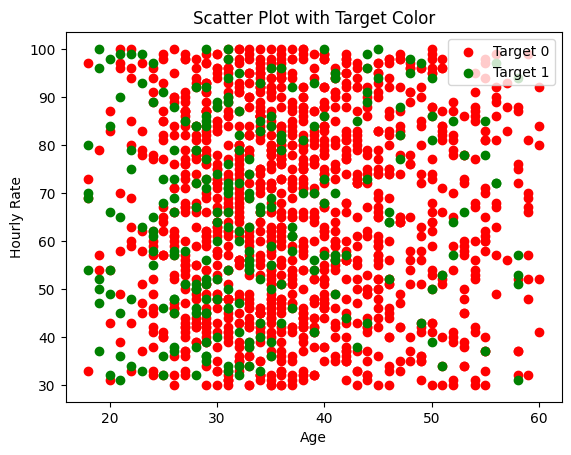

In [638]:
# Extract the 'Age', 'DistancefromHome', and 'y_train' columns from the DataFrame
x1 = df['Age']
x2 = df['HourlyRate']
y_train = df['Attrition']

# Create a scatter plot with red color for y_train == 0 and green color for y_train == 1
plt.scatter(x1[y_train == 0], x2[y_train == 0], color='red', label='Target 0')
plt.scatter(x1[y_train == 1], x2[y_train == 1], color='green', label='Target 1')

# Set labels and title
plt.xlabel('Age')
plt.ylabel('Hourly Rate')
plt.title('Scatter Plot with Target Color')

# Add legend
plt.legend()

# Show the plot
plt.show()

# Data Preprocessing

Let's choose the variables that will be the input features of the model

In [639]:
features = [x for x in df.columns if x not in 'Attrition'] ## Removing our target variable

In [640]:
print(len(features))

53


Splitting the Dataset into Cross Validation (Development), Train and Test sets

In [641]:
X_train, X_, y_train, y_ = train_test_split(df[features],df['Attrition'], train_size= 0.6, random_state=RANDOM_STATE)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_, train_size= 0.5, random_state=RANDOM_STATE)
del X_, y_

In [642]:
print(f'Train samples: {len(X_train)}')
print(f'Validation samples: {len(X_cv)}')
print(f'Test samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

Train samples: 882
Validation samples: 294
Test samples: 294
target proportion: 0.1735


Decision trees are not affected by the scale of the features, thus scaling is not necessary, since decision trees make splits based on the values of features and their relationships, rather than the magnitude of the values. 

So we can jump into building the model.

# Building the model

In [643]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train,y_train, eval_set = [(X_cv,y_cv)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.64055
[1]	validation_0-logloss:0.59550
[2]	validation_0-logloss:0.56280
[3]	validation_0-logloss:0.53177
[4]	validation_0-logloss:0.50763
[5]	validation_0-logloss:0.48408
[6]	validation_0-logloss:0.46265
[7]	validation_0-logloss:0.44408
[8]	validation_0-logloss:0.42724
[9]	validation_0-logloss:0.41543
[10]	validation_0-logloss:0.40406
[11]	validation_0-logloss:0.39575
[12]	validation_0-logloss:0.38761
[13]	validation_0-logloss:0.38096
[14]	validation_0-logloss:0.37370
[15]	validation_0-logloss:0.36839
[16]	validation_0-logloss:0.36259
[17]	validation_0-logloss:0.35592
[18]	validation_0-logloss:0.34953
[19]	validation_0-logloss:0.34618
[20]	validation_0-logloss:0.34352
[21]	validation_0-logloss:0.33997
[22]	validation_0-logloss:0.33763
[23]	validation_0-logloss:0.33364
[24]	validation_0-logloss:0.33209
[25]	validation_0-logloss:0.32947
[26]	validation_0-logloss:0.32867
[27]	validation_0-logloss:0.32716
[28]	validation_0-logloss:0.32588
[29]	validation_0-loglos

C:\Users\a845930\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=55, ...)

In [644]:
xgb_model.best_iteration

42

In [645]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics c-validation:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_cv),y_cv):.4f}")

Metrics train:
	Accuracy score: 0.9875
Metrics c-validation:
	Accuracy score: 0.8673


Let's test the accuracy score on the test set

In [646]:
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics test:
	Accuracy score: 0.8401
